# Neural Graph Collaborative Filtering on MovieLens
> Applying NGCF PyTorch version on Movielens-100k

- toc: true
- badges: true
- comments: true
- categories: [Graph, PyTorch, Movie]
- author: "<a href='https://github.com/metahexane/ngcf_pytorch_g61'>Muhammed Imran Özyar</a>"
- image:

## Libraries

In [ ]:
!pip install -q git+https://github.com/sparsh-ai/recochef

In [4]:
import os
import csv 
import argparse
import numpy as np
import pandas as pd
import random as rd
from time import time
from pathlib import Path
import scipy.sparse as sp
from datetime import datetime

import torch
from torch import nn
import torch.nn.functional as F

from recochef.preprocessing.split import chrono_split

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)

## Data Loading

The MovieLens 100K data set consists of 100,000 ratings from 1000 users on 1700 movies as described on [their website](https://grouplens.org/datasets/movielens/100k/).

In [1]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip

--2021-07-12 08:50:29--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  5.93MB/s    in 0.8s    

2021-07-12 08:50:30 (5.93 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [2]:
!unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [5]:
df = pd.read_csv('ml-100k/u.data', sep='\t', header=None, names=['USERID','ITEMID','RATING','TIMESTAMP'])
df.head()

,USERID,ITEMID,RATING,TIMESTAMP
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Train/Test Split

We split the data chronologically in 80:20 ratio. Validated the split for user 4.

In [6]:
df_train, df_test = chrono_split(df, ratio=0.8)

In [7]:
userid = 4

query = "USERID==@userid"
display(df.query(query))
display(df_train.query(query))
display(df_test.query(query))

,USERID,ITEMID,RATING,TIMESTAMP
1250,4,264,3,892004275
1329,4,303,5,892002352
2204,4,361,5,892002353
2526,4,357,4,892003525
3277,4,260,4,892004275
5960,4,356,3,892003459
12151,4,294,5,892004409
13893,4,288,4,892001445
16305,4,50,5,892003526
18930,4,354,5,892002353


,USERID,ITEMID,RATING,TIMESTAMP
24743,4,258,5,892001374
13893,4,288,4,892001445
20383,4,300,5,892001445
24519,4,328,3,892001537
20082,4,271,4,892001690
68273,4,359,5,892002352
71055,4,362,5,892002352
1329,4,303,5,892002352
51203,4,327,5,892002352
35313,4,329,5,892002352


,USERID,ITEMID,RATING,TIMESTAMP
76722,4,358,2,892004275
3277,4,260,4,892004275
1250,4,264,3,892004275
12151,4,294,5,892004409
48826,4,11,4,892004520


## Preprocessing

1. Sort by User ID and Timestamp
2. Label encode user and item id - in this case, already label encoded starting from 1, so decreasing ids by 1 as a proxy for label encode
3. Remove Timestamp and Rating column. The reason is that we are training a recall-maximing model where the objective is to correctly retrieve the items that users can interact with. We can select a rating threshold also
4. Convert Item IDs into list format
5. Store as a space-seperated txt file

In [8]:
def preprocess(data):
  data = data.copy()
  data = data.sort_values(by=['USERID','TIMESTAMP'])
  data['USERID'] = data['USERID'] - 1
  data['ITEMID'] = data['ITEMID'] - 1
  data.drop(['TIMESTAMP','RATING'], axis=1, inplace=True)
  data = data.groupby('USERID')['ITEMID'].apply(list).reset_index(name='ITEMID')
  return data

In [9]:
preprocess(df_train).head()

,USERID,ITEMID
0,0,"[167, 171, 164, 155, 165, 195, 186, 13, 249, 1..."
1,1,"[285, 257, 304, 306, 287, 311, 300, 305, 291, ..."
2,2,"[301, 332, 343, 299, 267, 336, 302, 344, 353, ..."
3,3,"[257, 287, 299, 327, 270, 358, 361, 302, 326, ..."
4,4,"[266, 454, 221, 120, 404, 362, 256, 249, 24, 2..."


In [10]:
def store(data, target_file='./data/movielens/train.txt'):
  Path(target_file).parent.mkdir(parents=True, exist_ok=True)
  with open(target_file, 'w+') as f:
    writer = csv.writer(f, delimiter=' ')
    for USERID, row in zip(data.USERID.values,data.ITEMID.values):
      row = [USERID] + row
      writer.writerow(row)

In [11]:
store(preprocess(df_train), '/content/data/ml-100k/train.txt')
store(preprocess(df_test), '/content/data/ml-100k/test.txt')

In [12]:
!head /content/data/ml-100k/train.txt

0 167 171 164 155 165 195 186 13 249 126 180 116 108 0 245 256 247 49 248 252 261 92 223 123 18 122 136 145 6 234 14 244 259 23 263 125 236 12 24 120 250 235 239 117 129 64 189 46 30 27 113 38 51 237 198 182 10 68 160 94 59 82 178 21 97 63 134 162 25 201 88 7 213 181 47 98 159 174 191 179 127 142 184 67 54 203 55 95 80 78 150 211 22 69 83 93 196 190 183 133 206 144 187 185 96 84 35 143 158 16 173 251 104 147 107 146 219 105 242 121 106 103 246 119 44 267 266 258 260 262 9 149 233 91 70 41 175 90 192 216 176 215 193 72 58 132 40 194 217 169 212 156 222 26 226 79 230 66 118 199 3 214 163 1 205 76 52 135 45 39 152 268 253 114 172 210 228 154 202 61 89 218 166 229 34 161 60 264 111 56 48 29 232 130 151 81 140 71 32 157 197 224 112 20 148 87 100 109 102 238 33 28 42 131 209 204 115 124
1 285 257 304 306 287 311 300 305 291 302 268 298 314 295 0 18 296 292 274 256 294 276 286 254 297 289 279 273 275 272 290 277 293 24 278 13 110 9 281 12 236 283 99 126 312 284 301 282 250 310
2 301 332 343 2

In [13]:
!head /content/data/ml-100k/test.txt

0 207 2 11 57 200 137 65 36 37 139 240 75 225 77 62 231 138 141 74 50 53 43 86 99 8 227 153 85 168 15 177 221 257 265 254 271 270 19 128 220 243 5 17 269 208 31 188 241 170 110 4 255 101 73
1 49 241 271 309 303 299 288 315 307 308 313 280
2 320 327 326 345 347 259 330 317 316 319 180
3 357 259 263 293 10
4 138 388 453 68 161 232 242 258 451 439 437 436 438 188 168 407 100 425 376 62 399 93 408 193 162 393 375 39 409 23 441 387 394 452 456
5 516 80 133 498 194 466 418 131 504 207 356 465 199 172 187 212 273 422 169 525 484 508 515 501 201 469 366 185 500 153 477 202 167 424 18 85 152 27 517 538 464 271
6 675 61 144 551 616 560 569 553 585 540 52 138 589 448 544 558 333 293 259 624 417 541 557 218 671 439 568 562 550 564 566 668 445 637 556 579 665 641 226 582 53 573 449 142 416 625 620 559 230 575 390 539 427 174 72 584 574 576 385 578 519 386 316 661 552 554 30 133 323 257 11 192 640 184 198 356 666 653 432 581 340
7 549 81 187 221 430 683 517 226 240 232 565 684
8 690 285 482 486
9 14

In [14]:
Path('/content/results').mkdir(parents=True, exist_ok=True)

In [70]:
def parse_args():
    parser = argparse.ArgumentParser(description="Run NGCF.")
    parser.add_argument('--data_dir', type=str,
                        default='./data/',
                        help='Input data path.')
    parser.add_argument('--dataset', type=str, default='ml-100k',
                        help='Dataset name: Amazond-book, Gowella, ml-100k')
    parser.add_argument('--results_dir', type=str, default='results',
                        help='Store model to path.')
    parser.add_argument('--n_epochs', type=int, default=400,
                        help='Number of epoch.')
    parser.add_argument('--reg', type=float, default=1e-5,
                        help='l2 reg.')
    parser.add_argument('--lr', type=float, default=0.0001,
                        help='Learning rate.')
    parser.add_argument('--emb_dim', type=int, default=64,
                        help='number of embeddings.')
    parser.add_argument('--layers', type=str, default='[64,64]',
                        help='Output sizes of every layer')
    parser.add_argument('--batch_size', type=int, default=512,
                        help='Batch size.')
    parser.add_argument('--node_dropout', type=float, default=0.,
                        help='Graph Node dropout.')
    parser.add_argument('--mess_dropout', type=float, default=0.1,
                        help='Message dropout.')
    parser.add_argument('--k', type=str, default=20,
                        help='k order of metric evaluation (e.g. NDCG@k)')
    parser.add_argument('--eval_N', type=int, default=5,
                        help='Evaluate every N epochs')
    parser.add_argument('--save_results', type=int, default=1,
                        help='Save model and results')

    return parser.parse_args(args={})

## Helper Functions

- early_stopping()
- train()
- split_matrix()
- ndcg_k()
- eval_model

### Early Stopping
Premature stopping is applied if *recall@20* on the test set does not increase for 5 successive epochs.

In [ ]:
def early_stopping(log_value, best_value, stopping_step, flag_step, expected_order='asc'):
    """
    Check if early_stopping is needed
    Function copied from original code
    """
    assert expected_order in ['asc', 'des']
    if (expected_order == 'asc' and log_value >= best_value) or (expected_order == 'des' and log_value <= best_value):
        stopping_step = 0
        best_value = log_value
    else:
        stopping_step += 1

    if stopping_step >= flag_step:
        print("Early stopping at step: {} log:{}".format(flag_step, log_value))
        should_stop = True
    else:
        should_stop = False

    return best_value, stopping_step, should_stop

In [71]:
def train(model, data_generator, optimizer):
    """
    Train the model PyTorch style
    Arguments:
    ---------
    model: PyTorch model
    data_generator: Data object
    optimizer: PyTorch optimizer
    """
    model.train()
    n_batch = data_generator.n_train // data_generator.batch_size + 1
    running_loss=0
    for _ in range(n_batch):
        u, i, j = data_generator.sample()
        optimizer.zero_grad()
        loss = model(u,i,j)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss

def split_matrix(X, n_splits=100):
    """
    Split a matrix/Tensor into n_folds (for the user embeddings and the R matrices)
    Arguments:
    ---------
    X: matrix to be split
    n_folds: number of folds
    Returns:
    -------
    splits: split matrices
    """
    splits = []
    chunk_size = X.shape[0] // n_splits
    for i in range(n_splits):
        start = i * chunk_size
        end = X.shape[0] if i == n_splits - 1 else (i + 1) * chunk_size
        splits.append(X[start:end])
    return splits

def compute_ndcg_k(pred_items, test_items, test_indices, k):
    """
    Compute NDCG@k
    
    Arguments:
    ---------
    pred_items: binary tensor with 1s in those locations corresponding to the predicted item interactions
    test_items: binary tensor with 1s in locations corresponding to the real test interactions
    test_indices: tensor with the location of the top-k predicted items
    k: k'th-order 
    Returns:
    -------
    NDCG@k
    """
    r = (test_items * pred_items).gather(1, test_indices)
    f = torch.from_numpy(np.log2(np.arange(2, k+2))).float().cuda()
    dcg = (r[:, :k]/f).sum(1)
    dcg_max = (torch.sort(r, dim=1, descending=True)[0][:, :k]/f).sum(1)
    ndcg = dcg/dcg_max
    ndcg[torch.isnan(ndcg)] = 0
    return ndcg

### Eval Model

At every N epoch, the model is evaluated on the test set. From this evaluation, we compute the recall and normal discounted cumulative gain (ndcg) at the top-20 predictions. It is important to note that in order to evaluate the model on the test set we have to ‘unpack’ the sparse matrix (torch.sparse.todense()), and thus load a bunch of ‘zeros’ on memory. In order to prevent memory overload, we split the sparse matrices into 100 chunks, unpack the sparse chunks one by one, compute the metrics we need, and compute the mean value of all chunks.

In [ ]:
def eval_model(u_emb, i_emb, Rtr, Rte, k):
    """
    Evaluate the model
    
    Arguments:
    ---------
    u_emb: User embeddings
    i_emb: Item embeddings
    Rtr: Sparse matrix with the training interactions
    Rte: Sparse matrix with the testing interactions
    k : kth-order for metrics
    
    Returns:
    --------
    result: Dictionary with lists correponding to the metrics at order k for k in Ks
    """
    # split matrices
    ue_splits = split_matrix(u_emb)
    tr_splits = split_matrix(Rtr)
    te_splits = split_matrix(Rte)

    recall_k, ndcg_k= [], []
    # compute results for split matrices
    for ue_f, tr_f, te_f in zip(ue_splits, tr_splits, te_splits):

        scores = torch.mm(ue_f, i_emb.t())

        test_items = torch.from_numpy(te_f.todense()).float().cuda()
        non_train_items = torch.from_numpy(1-(tr_f.todense())).float().cuda()
        scores = scores * non_train_items

        _, test_indices = torch.topk(scores, dim=1, k=k)

        # If you want to use a as the index in dim1 for t, this code should work:
        #t[torch.arange(t.size(0)), a]

        pred_items = torch.zeros_like(scores).float()
        # pred_items.scatter_(dim=1,index=test_indices,src=torch.tensor(1.0).cuda())
        pred_items.scatter_(dim=1,index=test_indices,src=torch.ones_like(test_indices, dtype=torch.float).cuda())

        topk_preds = torch.zeros_like(scores).float()
        # topk_preds.scatter_(dim=1,index=test_indices[:, :k],src=torch.tensor(1.0))
        _idx = test_indices[:, :k]
        topk_preds.scatter_(dim=1,index=_idx,src=torch.ones_like(_idx, dtype=torch.float))

        TP = (test_items * topk_preds).sum(1)
        rec = TP/test_items.sum(1)
        ndcg = compute_ndcg_k(pred_items, test_items, test_indices, k)

        recall_k.append(rec)
        ndcg_k.append(ndcg)

    return torch.cat(recall_k).mean(), torch.cat(ndcg_k).mean()

## Dataset Class

### Laplacian matrix

The components of the Laplacian matrix are as follows,

- **D**: a diagonal degree matrix, where D{t,t} is |N{t}|, which is the amount of first-hop neighbors for either item or user t,
- **R**: the user-item interaction matrix,
- **0**: an all-zero matrix,
- **A**: the adjacency matrix,

### Interaction and Adjacency Matrix

We create the sparse interaction matrix R, the adjacency matrix A, the degree matrix D, and the Laplacian matrix L, using the SciPy library. The adjacency matrix A is then transferred onto PyTorch tensor objects.

In [72]:
class Data(object):
    def __init__(self, path, batch_size):
        self.path = path
        self.batch_size = batch_size

        train_file = path + '/train.txt'
        test_file = path + '/test.txt'

        #get number of users and items
        self.n_users, self.n_items = 0, 0
        self.n_train, self.n_test = 0, 0
        self.neg_pools = {}

        self.exist_users = []

        # search train_file for max user_id/item_id
        with open(train_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n').split(' ')
                    items = [int(i) for i in l[1:]]
                    # first element is the user_id, rest are items
                    uid = int(l[0])
                    self.exist_users.append(uid)
                    # item/user with highest number is number of items/users
                    self.n_items = max(self.n_items, max(items))
                    self.n_users = max(self.n_users, uid)
                    # number of interactions
                    self.n_train += len(items)

        # search test_file for max item_id
        with open(test_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n')
                    try:
                        items = [int(i) for i in l.split(' ')[1:]]
                    except Exception:
                        continue
                    if not items:
                        print("empyt test exists")
                        pass
                    else:
                        self.n_items = max(self.n_items, max(items))
                        self.n_test += len(items)
        # adjust counters: user_id/item_id starts at 0
        self.n_items += 1
        self.n_users += 1

        self.print_statistics()

        # create interactions/ratings matrix 'R' # dok = dictionary of keys
        print('Creating interaction matrices R_train and R_test...')
        t1 = time()
        self.R_train = sp.dok_matrix((self.n_users, self.n_items), dtype=np.float32) 
        self.R_test = sp.dok_matrix((self.n_users, self.n_items), dtype=np.float32)

        self.train_items, self.test_set = {}, {}
        with open(train_file) as f_train:
            with open(test_file) as f_test:
                for l in f_train.readlines():
                    if len(l) == 0: break
                    l = l.strip('\n')
                    items = [int(i) for i in l.split(' ')]
                    uid, train_items = items[0], items[1:]
                    # enter 1 if user interacted with item
                    for i in train_items:
                        self.R_train[uid, i] = 1.
                    self.train_items[uid] = train_items

                for l in f_test.readlines():
                    if len(l) == 0: break
                    l = l.strip('\n')
                    try:
                        items = [int(i) for i in l.split(' ')]
                    except Exception:
                        continue
                    uid, test_items = items[0], items[1:]
                    for i in test_items:
                        self.R_test[uid, i] = 1.0
                    self.test_set[uid] = test_items
        print('Complete. Interaction matrices R_train and R_test created in', time() - t1, 'sec')

    # if exist, get adjacency matrix
    def get_adj_mat(self):
        try:
            t1 = time()
            adj_mat = sp.load_npz(self.path + '/s_adj_mat.npz')
            print('Loaded adjacency-matrix (shape:', adj_mat.shape,') in', time() - t1, 'sec.')

        except Exception:
            print('Creating adjacency-matrix...')
            adj_mat = self.create_adj_mat()
            sp.save_npz(self.path + '/s_adj_mat.npz', adj_mat)
        return adj_mat
    
    # create adjancency matrix
    def create_adj_mat(self):
        t1 = time()
        
        adj_mat = sp.dok_matrix((self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32)
        adj_mat = adj_mat.tolil()
        R = self.R_train.tolil() # to list of lists

        adj_mat[:self.n_users, self.n_users:] = R
        adj_mat[self.n_users:, :self.n_users] = R.T
        adj_mat = adj_mat.todok()
        print('Complete. Adjacency-matrix created in', adj_mat.shape, time() - t1, 'sec.')

        t2 = time()

        # normalize adjacency matrix
        def normalized_adj_single(adj):
            rowsum = np.array(adj.sum(1))

            d_inv = np.power(rowsum, -.5).flatten()
            d_inv[np.isinf(d_inv)] = 0.
            d_mat_inv = sp.diags(d_inv)

            norm_adj = d_mat_inv.dot(adj).dot(d_mat_inv)
            return norm_adj.tocoo()

        print('Transforming adjacency-matrix to NGCF-adjacency matrix...')
        ngcf_adj_mat = normalized_adj_single(adj_mat) + sp.eye(adj_mat.shape[0])

        print('Complete. Transformed adjacency-matrix to NGCF-adjacency matrix in', time() - t2, 'sec.')
        return ngcf_adj_mat.tocsr()

    # create collections of N items that users never interacted with
    def negative_pool(self):
        t1 = time()
        for u in self.train_items.keys():
            neg_items = list(set(range(self.n_items)) - set(self.train_items[u]))
            pools = [rd.choice(neg_items) for _ in range(100)]
            self.neg_pools[u] = pools
        print('refresh negative pools', time() - t1)

    # sample data for mini-batches
    def sample(self):
        if self.batch_size <= self.n_users:
            users = rd.sample(self.exist_users, self.batch_size)
        else:
            users = [rd.choice(self.exist_users) for _ in range(self.batch_size)]

        def sample_pos_items_for_u(u, num):
            pos_items = self.train_items[u]
            n_pos_items = len(pos_items)
            pos_batch = []
            while True:
                if len(pos_batch) == num: break
                pos_id = np.random.randint(low=0, high=n_pos_items, size=1)[0]
                pos_i_id = pos_items[pos_id]

                if pos_i_id not in pos_batch:
                    pos_batch.append(pos_i_id)
            return pos_batch

        def sample_neg_items_for_u(u, num):
            neg_items = []
            while True:
                if len(neg_items) == num: break
                neg_id = np.random.randint(low=0, high=self.n_items,size=1)[0]
                if neg_id not in self.train_items[u] and neg_id not in neg_items:
                    neg_items.append(neg_id)
            return neg_items

        def sample_neg_items_for_u_from_pools(u, num):
            neg_items = list(set(self.neg_pools[u]) - set(self.train_items[u]))
            return rd.sample(neg_items, num)

        pos_items, neg_items = [], []
        for u in users:
            pos_items += sample_pos_items_for_u(u, 1)
            neg_items += sample_neg_items_for_u(u, 1)

        return users, pos_items, neg_items

    def get_num_users_items(self):
        return self.n_users, self.n_items

    def print_statistics(self):
        print('n_users=%d, n_items=%d' % (self.n_users, self.n_items))
        print('n_interactions=%d' % (self.n_train + self.n_test))
        print('n_train=%d, n_test=%d, sparsity=%.5f' % (self.n_train, self.n_test, (self.n_train + self.n_test)/(self.n_users * self.n_items)))

## NGCF Model

### Weight initialization

We then create tensors for the user embeddings and item embeddings with the proper dimensions. The weights are initialized using [Xavier uniform initialization](https://pytorch.org/docs/stable/nn.init.html).

For each layer, the weight matrices and corresponding biases are initialized using the same procedure.

### Embedding Layer

The initial user and item embeddings are concatenated in an embedding lookup table as shown in the figure below. This embedding table is initialized using the user and item embeddings and will be optimized in an end-to-end fashion by the network.

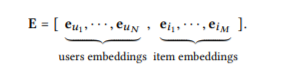

### Embedding propagation

The embedding table is propagated through the network using the formula shown in the figure below.

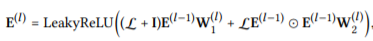

The components of the formula are as follows,

- **E⁽ˡ⁾**: the embedding table after l steps of embedding propagation, where E⁽⁰⁾ is the initial embedding table,
- **LeakyReLU**: the rectified linear unit used as activation function,
- **W**: the weights trained by the network,
- **I**: an identity matrix,
- **L**: the Laplacian matrix for the user-item graph, which is formulated as

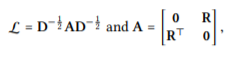

### Architecture

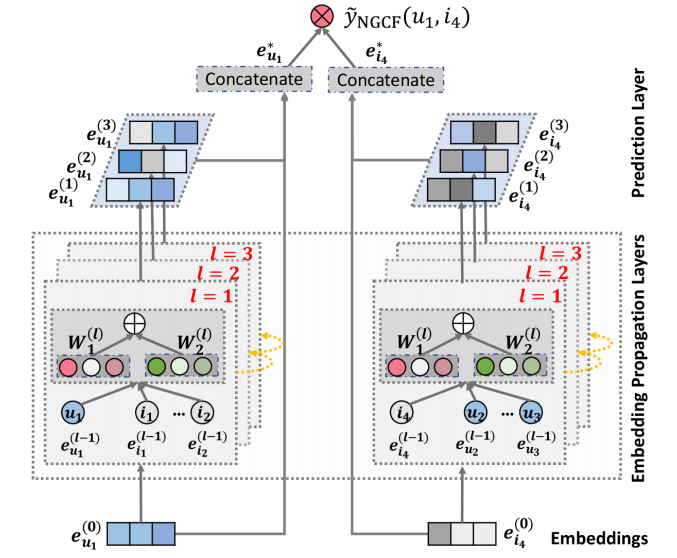

In [73]:
class NGCF(nn.Module):
    def __init__(self, n_users, n_items, emb_dim, layers, reg, node_dropout, mess_dropout,
        adj_mtx):
        super().__init__()

        # initialize Class attributes
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.adj_mtx = adj_mtx
        self.laplacian = adj_mtx - sp.eye(adj_mtx.shape[0])
        self.reg = reg
        self.layers = layers
        self.n_layers = len(self.layers)
        self.node_dropout = node_dropout
        self.mess_dropout = mess_dropout

        #self.u_g_embeddings = nn.Parameter(torch.empty(n_users, emb_dim+np.sum(self.layers)))
        #self.i_g_embeddings = nn.Parameter(torch.empty(n_items, emb_dim+np.sum(self.layers)))

        # Initialize weights
        self.weight_dict = self._init_weights()
        print("Weights initialized.")

        # Create Matrix 'A', PyTorch sparse tensor of SP adjacency_mtx
        self.A = self._convert_sp_mat_to_sp_tensor(self.adj_mtx)
        self.L = self._convert_sp_mat_to_sp_tensor(self.laplacian)

    # initialize weights
    def _init_weights(self):
        print("Initializing weights...")
        weight_dict = nn.ParameterDict()

        initializer = torch.nn.init.xavier_uniform_
        
        weight_dict['user_embedding'] = nn.Parameter(initializer(torch.empty(self.n_users, self.emb_dim).to(device)))
        weight_dict['item_embedding'] = nn.Parameter(initializer(torch.empty(self.n_items, self.emb_dim).to(device)))

        weight_size_list = [self.emb_dim] + self.layers

        for k in range(self.n_layers):
            weight_dict['W_gc_%d' %k] = nn.Parameter(initializer(torch.empty(weight_size_list[k], weight_size_list[k+1]).to(device)))
            weight_dict['b_gc_%d' %k] = nn.Parameter(initializer(torch.empty(1, weight_size_list[k+1]).to(device)))
            
            weight_dict['W_bi_%d' %k] = nn.Parameter(initializer(torch.empty(weight_size_list[k], weight_size_list[k+1]).to(device)))
            weight_dict['b_bi_%d' %k] = nn.Parameter(initializer(torch.empty(1, weight_size_list[k+1]).to(device)))
           
        return weight_dict

    # convert sparse matrix into sparse PyTorch tensor
    def _convert_sp_mat_to_sp_tensor(self, X):
        """
        Convert scipy sparse matrix to PyTorch sparse matrix
        Arguments:
        ----------
        X = Adjacency matrix, scipy sparse matrix
        """
        coo = X.tocoo().astype(np.float32)
        i = torch.LongTensor(np.mat([coo.row, coo.col]))
        v = torch.FloatTensor(coo.data)
        res = torch.sparse.FloatTensor(i, v, coo.shape).to(device)
        return res

    # apply node_dropout
    def _droupout_sparse(self, X):
        """
        Drop individual locations in X
        
        Arguments:
        ---------
        X = adjacency matrix (PyTorch sparse tensor)
        dropout = fraction of nodes to drop
        noise_shape = number of non non-zero entries of X
        """
        
        node_dropout_mask = ((self.node_dropout) + torch.rand(X._nnz())).floor().bool().to(device)
        i = X.coalesce().indices()
        v = X.coalesce()._values()
        i[:,node_dropout_mask] = 0
        v[node_dropout_mask] = 0
        X_dropout = torch.sparse.FloatTensor(i, v, X.shape).to(X.device)

        return  X_dropout.mul(1/(1-self.node_dropout))

    def forward(self, u, i, j):
        """
        Computes the forward pass
        
        Arguments:
        ---------
        u = user
        i = positive item (user interacted with item)
        j = negative item (user did not interact with item)
        """
        # apply drop-out mask
        A_hat = self._droupout_sparse(self.A) if self.node_dropout > 0 else self.A
        L_hat = self._droupout_sparse(self.L) if self.node_dropout > 0 else self.L

        ego_embeddings = torch.cat([self.weight_dict['user_embedding'], self.weight_dict['item_embedding']], 0)

        all_embeddings = [ego_embeddings]

        # forward pass for 'n' propagation layers
        for k in range(self.n_layers):

            # weighted sum messages of neighbours
            side_embeddings = torch.sparse.mm(A_hat, ego_embeddings)
            side_L_embeddings = torch.sparse.mm(L_hat, ego_embeddings)

            # transformed sum weighted sum messages of neighbours
            sum_embeddings = torch.matmul(side_embeddings, self.weight_dict['W_gc_%d' % k]) + self.weight_dict['b_gc_%d' % k]

            # bi messages of neighbours
            bi_embeddings = torch.mul(ego_embeddings, side_L_embeddings)
            # transformed bi messages of neighbours
            bi_embeddings = torch.matmul(bi_embeddings, self.weight_dict['W_bi_%d' % k]) + self.weight_dict['b_bi_%d' % k]

            # non-linear activation 
            ego_embeddings = F.leaky_relu(sum_embeddings + bi_embeddings)
            # + message dropout
            mess_dropout_mask = nn.Dropout(self.mess_dropout)
            ego_embeddings = mess_dropout_mask(ego_embeddings)

            # normalize activation
            norm_embeddings = F.normalize(ego_embeddings, p=2, dim=1)

            all_embeddings.append(norm_embeddings)

        all_embeddings = torch.cat(all_embeddings, 1)
        
        # back to user/item dimension
        u_g_embeddings, i_g_embeddings = all_embeddings.split([self.n_users, self.n_items], 0)

        self.u_g_embeddings = nn.Parameter(u_g_embeddings)
        self.i_g_embeddings = nn.Parameter(i_g_embeddings)
        
        u_emb = u_g_embeddings[u] # user embeddings
        p_emb = i_g_embeddings[i] # positive item embeddings
        n_emb = i_g_embeddings[j] # negative item embeddings

        y_ui = torch.mul(u_emb, p_emb).sum(dim=1)
        y_uj = torch.mul(u_emb, n_emb).sum(dim=1)
        log_prob = (torch.log(torch.sigmoid(y_ui-y_uj))).mean()

        # compute bpr-loss
        bpr_loss = -log_prob
        if self.reg > 0.:
            l2norm = (torch.sum(u_emb**2)/2. + torch.sum(p_emb**2)/2. + torch.sum(n_emb**2)/2.) / u_emb.shape[0]
            l2reg  = self.reg*l2norm
            bpr_loss =  -log_prob + l2reg

        return bpr_loss

## Training and Evaluation

Training is done using the standard PyTorch method. If you are already familiar with PyTorch, the following code should look familiar.

One of the most useful functions of PyTorch is the torch.nn.Sequential() function, that takes existing and custom torch.nn modules. This makes it very easy to build and train complete networks. However, due to the nature of NCGF model structure, usage of torch.nn.Sequential() is not possible and the forward pass of the network has to be implemented ‘manually’. Using the Bayesian personalized ranking (BPR) pairwise loss, the forward pass is implemented as follows:

n_users=943, n_items=1682
n_interactions=100000
n_train=80000, n_test=20000, sparsity=0.06305
Creating interaction matrices R_train and R_test...
Complete. Interaction matrices R_train and R_test created in 1.4850668907165527 sec
Loaded adjacency-matrix (shape: (2625, 2625) ) in 0.018111467361450195 sec.
Initializing weights...
Weights initialized.
Start at 2021-07-12 09:57:58.311285
Using cuda for computations
Params on CUDA: True
Epoch: 0, Training time: 9.11s, Loss: 107.9355
Epoch: 1, Training time: 8.88s, Loss: 101.6095
Epoch: 2, Training time: 8.75s, Loss: 80.7764
Epoch: 3, Training time: 8.76s, Loss: 76.1915
Epoch: 4, Training time: 8.58s, Loss: 73.0698
Evaluate current model:
 Epoch: 4, Validation time: 1.51s 
 Loss: 73.0698: 
 Recall@20: 0.0623 
 NDCG@20: 0.2352
Epoch: 5, Training time: 8.84s, Loss: 69.3378
Epoch: 6, Training time: 8.71s, Loss: 64.4498
Epoch: 7, Training time: 8.67s, Loss: 60.1440
Epoch: 8, Training time: 8.76s, Loss: 56.8538
Epoch: 9, Training time: 8.78s, Los

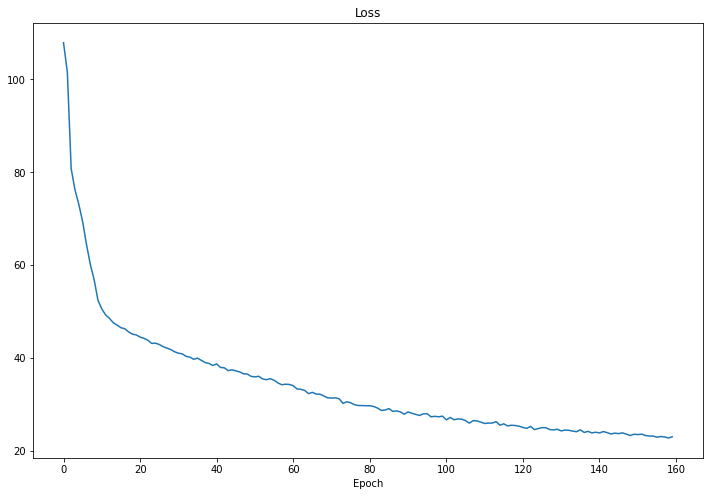

In [74]:
# read parsed arguments
args = parse_args()
data_dir = args.data_dir
dataset = args.dataset
batch_size = args.batch_size
layers = eval(args.layers)
emb_dim = args.emb_dim
lr = args.lr
reg = args.reg
mess_dropout = args.mess_dropout
node_dropout = args.node_dropout
k = args.k

# generate the NGCF-adjacency matrix
data_generator = Data(path=data_dir + dataset, batch_size=batch_size)
adj_mtx = data_generator.get_adj_mat()

# create model name and save
modelname =  "NGCF" + \
    "_bs_" + str(batch_size) + \
    "_nemb_" + str(emb_dim) + \
    "_layers_" + str(layers) + \
    "_nodedr_" + str(node_dropout) + \
    "_messdr_" + str(mess_dropout) + \
    "_reg_" + str(reg) + \
    "_lr_"  + str(lr)

# create NGCF model
model = NGCF(data_generator.n_users, 
              data_generator.n_items,
              emb_dim,
              layers,
              reg,
              node_dropout,
              mess_dropout,
              adj_mtx)
if use_cuda:
    model = model.cuda()

# current best metric
cur_best_metric = 0

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

# Set values for early stopping
cur_best_loss, stopping_step, should_stop = 1e3, 0, False
today = datetime.now()

print("Start at " + str(today))
print("Using " + str(device) + " for computations")
print("Params on CUDA: " + str(next(model.parameters()).is_cuda))

results = {"Epoch": [],
            "Loss": [],
            "Recall": [],
            "NDCG": [],
            "Training Time": []}

for epoch in range(args.n_epochs):

    t1 = time()
    loss = train(model, data_generator, optimizer)
    training_time = time()-t1
    print("Epoch: {}, Training time: {:.2f}s, Loss: {:.4f}".
        format(epoch, training_time, loss))

    # print test evaluation metrics every N epochs (provided by args.eval_N)
    if epoch % args.eval_N  == (args.eval_N - 1):
        with torch.no_grad():
            t2 = time()
            recall, ndcg = eval_model(model.u_g_embeddings.detach(),
                                      model.i_g_embeddings.detach(),
                                      data_generator.R_train,
                                      data_generator.R_test,
                                      k)
        print(
            "Evaluate current model:\n",
            "Epoch: {}, Validation time: {:.2f}s".format(epoch, time()-t2),"\n",
            "Loss: {:.4f}:".format(loss), "\n",
            "Recall@{}: {:.4f}".format(k, recall), "\n",
            "NDCG@{}: {:.4f}".format(k, ndcg)
            )

        cur_best_metric, stopping_step, should_stop = \
        early_stopping(recall, cur_best_metric, stopping_step, flag_step=5)

        # save results in dict
        results['Epoch'].append(epoch)
        results['Loss'].append(loss)
        results['Recall'].append(recall.item())
        results['NDCG'].append(ndcg.item())
        results['Training Time'].append(training_time)
    else:
        # save results in dict
        results['Epoch'].append(epoch)
        results['Loss'].append(loss)
        results['Recall'].append(None)
        results['NDCG'].append(None)
        results['Training Time'].append(training_time)

    if should_stop == True: break

# save
if args.save_results:
    date = today.strftime("%d%m%Y_%H%M")

    # save model as .pt file
    if os.path.isdir("./models"):
        torch.save(model.state_dict(), "./models/" + str(date) + "_" + modelname + "_" + dataset + ".pt")
    else:
        os.mkdir("./models")
        torch.save(model.state_dict(), "./models/" + str(date) + "_" + modelname + "_" + dataset + ".pt")

    # save results as pandas dataframe
    results_df = pd.DataFrame(results)
    results_df.set_index('Epoch', inplace=True)
    if os.path.isdir("./results"):
        results_df.to_csv("./results/" + str(date) + "_" + modelname + "_" + dataset + ".csv")
    else:
        os.mkdir("./results")
        results_df.to_csv("./results/" + str(date) + "_" + modelname + "_" + dataset + ".csv")
    # plot loss
    results_df['Loss'].plot(figsize=(12,8), title='Loss')

## Appendix

### References
1. [https://medium.com/@yusufnoor_88274/implementing-neural-graph-collaborative-filtering-in-pytorch-4d021dff25f3](https://medium.com/@yusufnoor_88274/implementing-neural-graph-collaborative-filtering-in-pytorch-4d021dff25f3)
2. [https://github.com/xiangwang1223/neural_graph_collaborative_filtering](https://github.com/xiangwang1223/neural_graph_collaborative_filtering)
3. [https://arxiv.org/pdf/1905.08108.pdf](https://arxiv.org/pdf/1905.08108.pdf)
4. [https://github.com/metahexane/ngcf_pytorch_g61](https://github.com/metahexane/ngcf_pytorch_g61)

### Next

Try out this notebook on the following datasets:
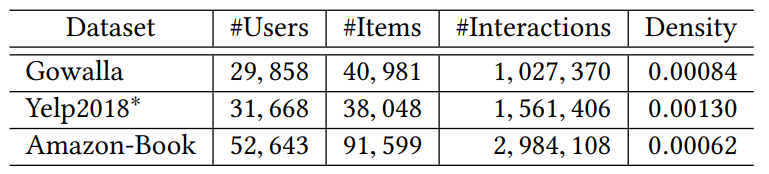

Compare out the performance with these baselines:

1. MF: This is matrix factorization optimized by the Bayesian
personalized ranking (BPR) loss, which exploits the user-item
direct interactions only as the target value of interaction function.
2. NeuMF: The method is a state-of-the-art neural CF model
which uses multiple hidden layers above the element-wise and
concatenation of user and item embeddings to capture their nonlinear feature interactions. Especially, we employ two-layered
plain architecture, where the dimension of each hidden layer
keeps the same.
3. CMN: It is a state-of-the-art memory-based model, where
the user representation attentively combines the memory slots
of neighboring users via the memory layers. Note that the firstorder connections are used to find similar users who interacted
with the same items.
4. HOP-Rec: This is a state-of-the-art graph-based model,
where the high-order neighbors derived from random walks
are exploited to enrich the user-item interaction data.
5. PinSage: PinSage is designed to employ GraphSAGE
on item-item graph. In this work, we apply it on user-item interaction graph. Especially, we employ two graph convolution
layers, and the hidden dimension is set equal
to the embedding size.
6. GC-MC: This model adopts GCN encoder to generate
the representations for users and items, where only the first-order
neighbors are considered. Hence one graph convolution layer,
where the hidden dimension is set as the embedding size, is used.